In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import random
import requests
import datetime
import os
import holidays
import seaborn as sns
import matplotlib.pyplot as plt



In [3]:
# Define possible file paths
path1 = r"C:\Users\TPWODL\New folder_Content\TimeSeriesForecasting_End_To_End\data\raw\Energy Demand Forcasting.csv"
path2 = r"C:\Users\LENOVO\MachineLearningProhects\TimeSeriesForecasting_End_To_End\data\raw\Energy Demand Forcasting.csv"

# Check which path exists and read CSV
if os.path.exists(path1):
    data = pd.read_csv(path1)
elif os.path.exists(path2):
    data = pd.read_csv(path2)
else:
    raise FileNotFoundError("❌ No valid data file found in either specified path.")

In [4]:
# STEP 2 — Define location (latitude, longitude)
# Example: Odisha, India

latitude = 20.9517
longitude = 85.0985

In [5]:
data

,date,megawatthours
0,2015-07-01 05:00:00,162827
1,2015-07-01 06:00:00,335153
2,2015-07-01 07:00:00,333837
3,2015-07-01 08:00:00,398386
4,2015-07-01 09:00:00,388954
...,...,...
58931,2022-03-21 16:00:00,433344
58932,2022-03-21 17:00:00,429156
58933,2022-03-21 18:00:00,426496
58934,2022-03-21 19:00:00,423393


In [6]:
data.tail()

,date,megawatthours
58931,2022-03-21 16:00:00,433344
58932,2022-03-21 17:00:00,429156
58933,2022-03-21 18:00:00,426496
58934,2022-03-21 19:00:00,423393
58935,2022-03-21 20:00:00,420157


In [7]:
data.shape


(58936, 2)

In [8]:
data = data.sort_values("date")

In [9]:
data['date'] = pd.to_datetime(data['date'])

In [10]:
start_date = data['date'].min().strftime("%Y-%m-%d")
end_date = data['date'].max().strftime("%Y-%m-%d")

url = (
    f"https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={latitude}&longitude={longitude}"
    f"&start_date={start_date}&end_date={end_date}"
    f"&hourly=temperature_2m,relative_humidity_2m"
)

In [11]:
start_date

'2015-07-01'

In [12]:
end_date

'2022-03-21'

In [13]:
response = requests.get(url)

In [14]:
weather_df = response.json()

In [15]:
weather_data = pd.DataFrame({
    "datetime": pd.to_datetime(weather_df["hourly"]["time"]),
    "temperature": weather_df["hourly"]["temperature_2m"],
    "humidity": weather_df["hourly"]["relative_humidity_2m"]
})

In [16]:
weather_data

,datetime,temperature,humidity
0,2015-07-01 00:00:00,24.8,95
1,2015-07-01 01:00:00,25.1,94
2,2015-07-01 02:00:00,25.8,90
3,2015-07-01 03:00:00,26.2,87
4,2015-07-01 04:00:00,27.4,82
...,...,...,...
58939,2022-03-21 19:00:00,24.1,77
58940,2022-03-21 20:00:00,23.8,84
58941,2022-03-21 21:00:00,24.2,86
58942,2022-03-21 22:00:00,22.6,94


In [17]:
df1 = data['megawatthours'].rename('megawatt_hours')

In [18]:
df = pd.concat([weather_data, df1], axis=1)

In [19]:
df

,datetime,temperature,humidity,megawatt_hours
0,2015-07-01 00:00:00,24.8,95,162827.0
1,2015-07-01 01:00:00,25.1,94,335153.0
2,2015-07-01 02:00:00,25.8,90,333837.0
3,2015-07-01 03:00:00,26.2,87,398386.0
4,2015-07-01 04:00:00,27.4,82,388954.0
...,...,...,...,...
58939,2022-03-21 19:00:00,24.1,77,NaN
58940,2022-03-21 20:00:00,23.8,84,NaN
58941,2022-03-21 21:00:00,24.2,86,NaN
58942,2022-03-21 22:00:00,22.6,94,NaN


In [20]:
print(df.isnull().sum())
df.dropna(inplace=True)

datetime          0
temperature       0
humidity          0
megawatt_hours    8
dtype: int64


In [21]:
df.shape

(58936, 4)

In [22]:
# ===== CORE TIME FEATURES =====
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['day_of_month'] = df['datetime'].dt.day
df['week_of_year'] = df['datetime'].dt.isocalendar().week.astype(int)
df['month'] = df['datetime'].dt.month
df['quarter'] = df['datetime'].dt.quarter
df['year'] = df['datetime'].dt.year
df['day_of_year'] = df['datetime'].dt.dayofyear
#df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# ===== CYCLIC ENCODINGS =====
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

df['lag_1'] = df['megawatt_hours'].shift(1)
df['lag_24'] = df['megawatt_hours'].shift(24)
df['lag_168'] = df['megawatt_hours'].shift(168)
df['rolling_mean_24'] = df['megawatt_hours'].shift(1).rolling(window=24).mean()
df['rolling_std_24'] = df['megawatt_hours'].shift(1).rolling(window=24).std()

In [23]:
df.head(5)

,datetime,temperature,humidity,megawatt_hours,hour,day_of_week,day_of_month,week_of_year,month,quarter,...,hour_cos,month_sin,month_cos,dayofweek_sin,dayofweek_cos,lag_1,lag_24,lag_168,rolling_mean_24,rolling_std_24
0,2015-07-01 00:00:00,24.8,95,162827.0,0,2,1,27,7,3,...,1.000000,-0.5,-0.866025,0.974928,-0.222521,NaN,NaN,NaN,NaN,NaN
1,2015-07-01 01:00:00,25.1,94,335153.0,1,2,1,27,7,3,...,0.965926,-0.5,-0.866025,0.974928,-0.222521,162827.0,NaN,NaN,NaN,NaN
2,2015-07-01 02:00:00,25.8,90,333837.0,2,2,1,27,7,3,...,0.866025,-0.5,-0.866025,0.974928,-0.222521,335153.0,NaN,NaN,NaN,NaN
3,2015-07-01 03:00:00,26.2,87,398386.0,3,2,1,27,7,3,...,0.707107,-0.5,-0.866025,0.974928,-0.222521,333837.0,NaN,NaN,NaN,NaN
4,2015-07-01 04:00:00,27.4,82,388954.0,4,2,1,27,7,3,...,0.500000,-0.5,-0.866025,0.974928,-0.222521,398386.0,NaN,NaN,NaN,NaN


array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'temperature'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'megawatt_hours'}>,
        <Axes: title={'center': 'hour'}>],
       [<Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'day_of_month'}>,
        <Axes: title={'center': 'week_of_year'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'quarter'}>],
       [<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'day_of_year'}>,
        <Axes: title={'center': 'hour_sin'}>,
        <Axes: title={'center': 'hour_cos'}>,
        <Axes: title={'center': 'month_sin'}>],
       [<Axes: title={'center': 'month_cos'}>,
        <Axes: title={'center': 'dayofweek_sin'}>,
        <Axes: title={'center': 'dayofweek_cos'}>,
        <Axes: title={'center': 'lag_1'}>,
        <Axes: title={'center': 'lag_24'}>],
       [<Axes: title={'center': 'lag_168'}>,
        <Axes

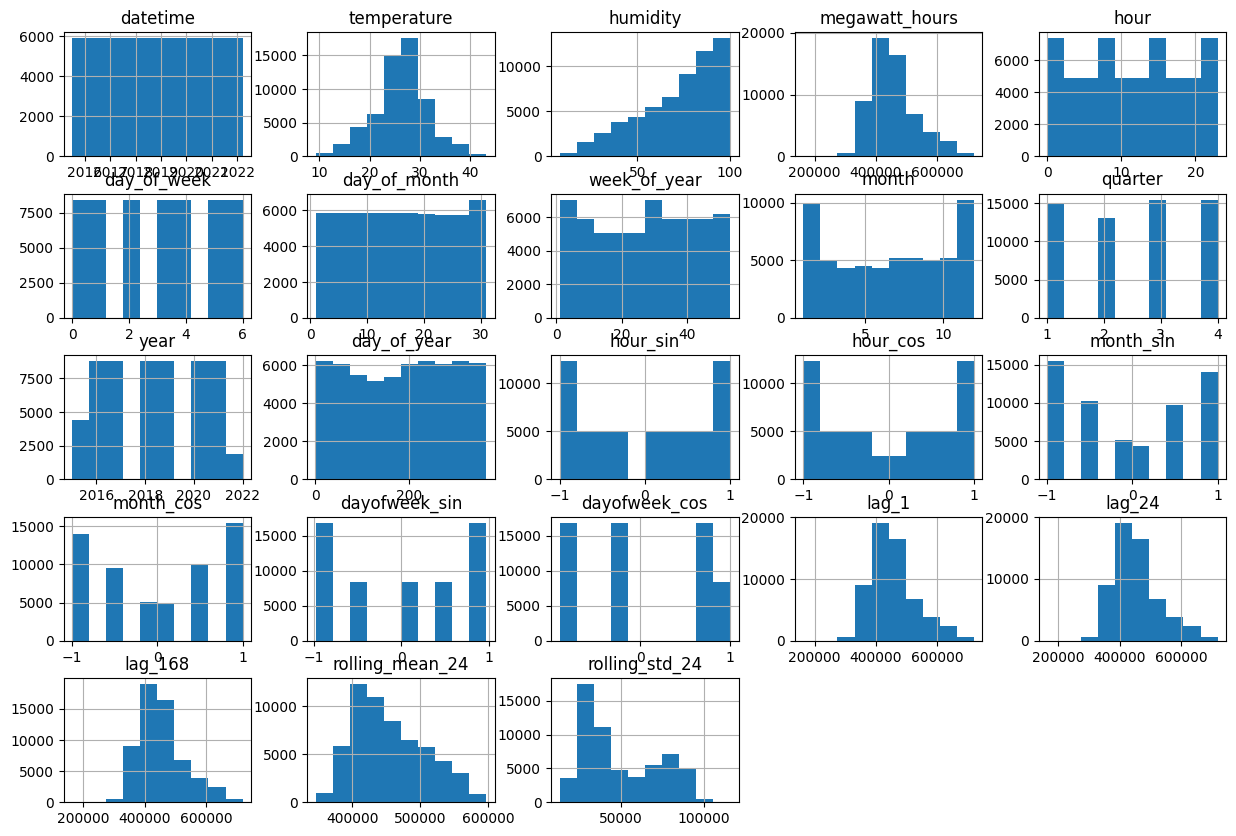

In [24]:
df.hist(figsize=(15, 10))

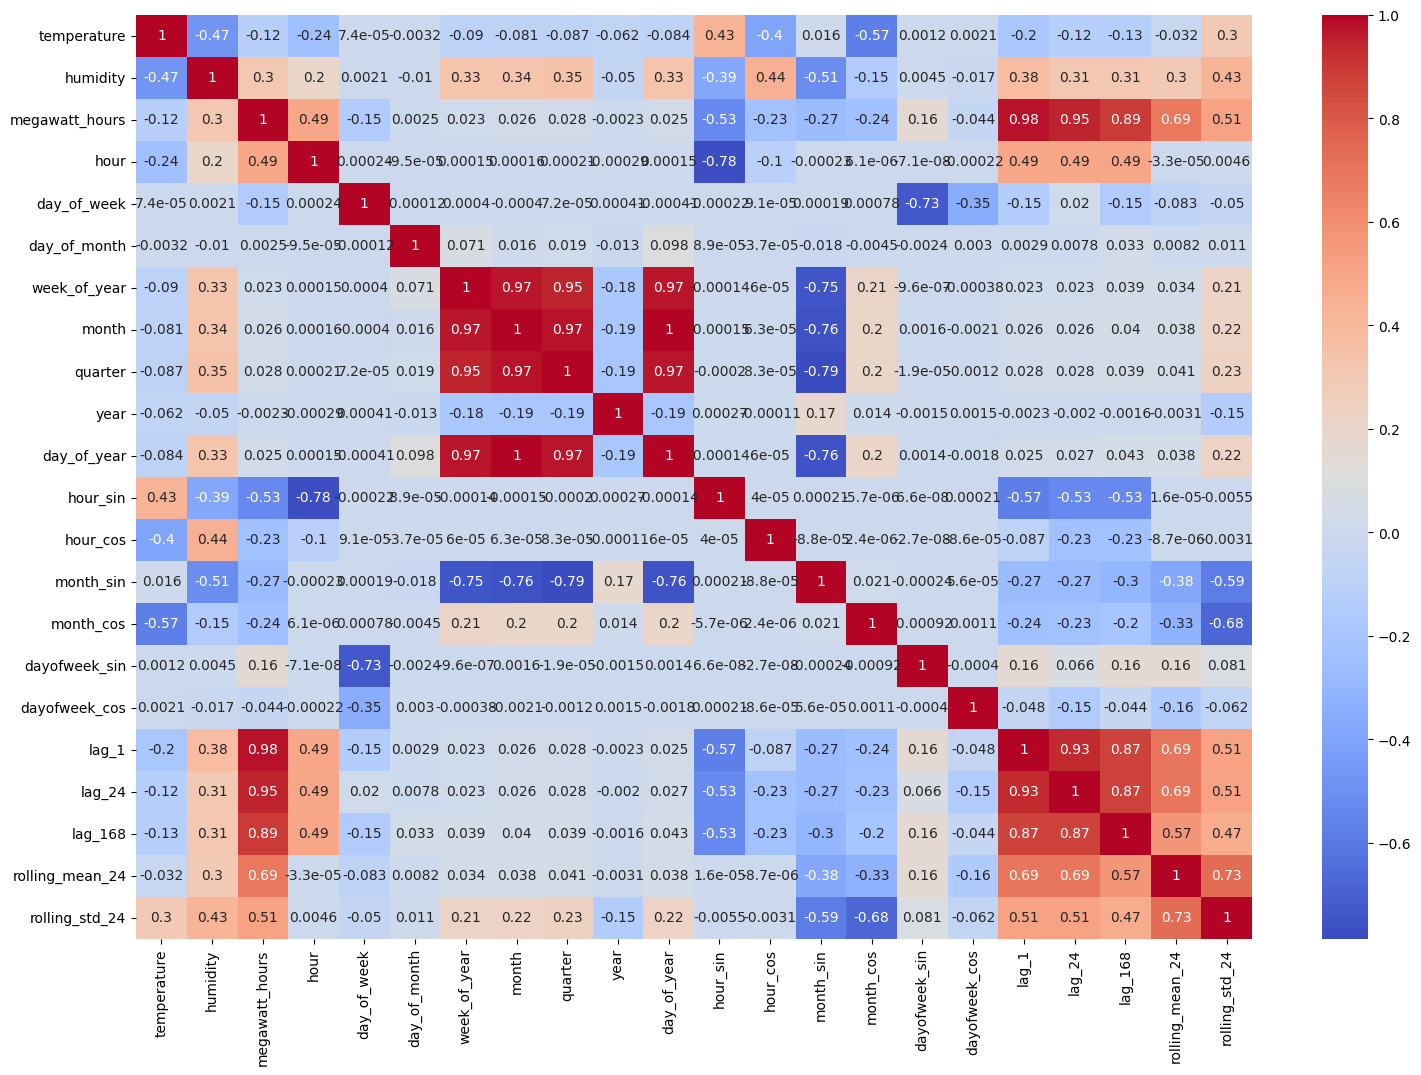

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 12))  # Adjust width and height as needed
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

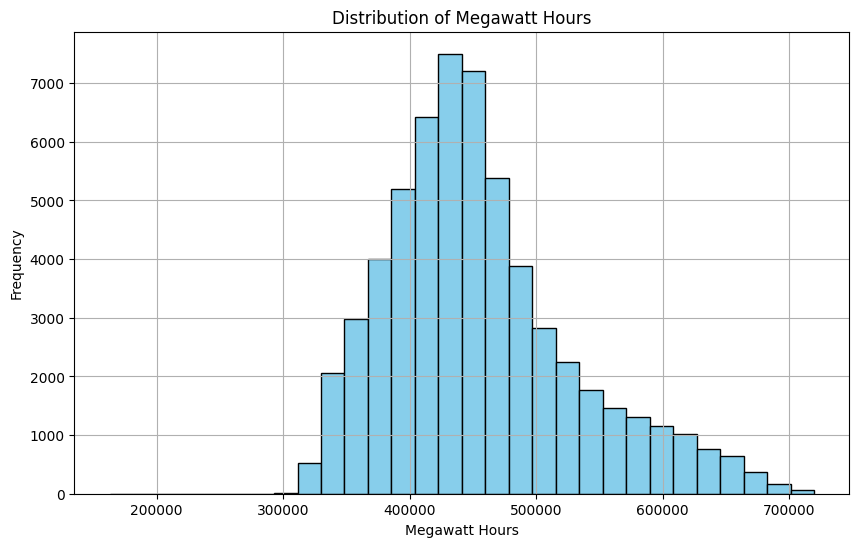

In [26]:
plt.figure(figsize=(10, 6))
plt.hist(df['megawatt_hours'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Megawatt Hours')
plt.xlabel('Megawatt Hours')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1240\962469038.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['megawatt_hours'], shade=True, color='purple')


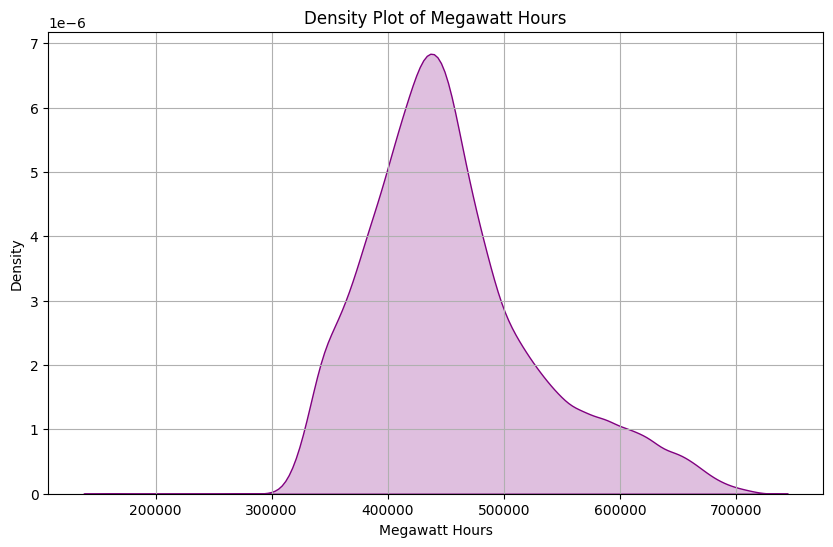

In [27]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['megawatt_hours'], shade=True, color='purple')
plt.title('Density Plot of Megawatt Hours')
plt.xlabel('Megawatt Hours')
plt.ylabel('Density')
plt.grid(True)
plt.show()

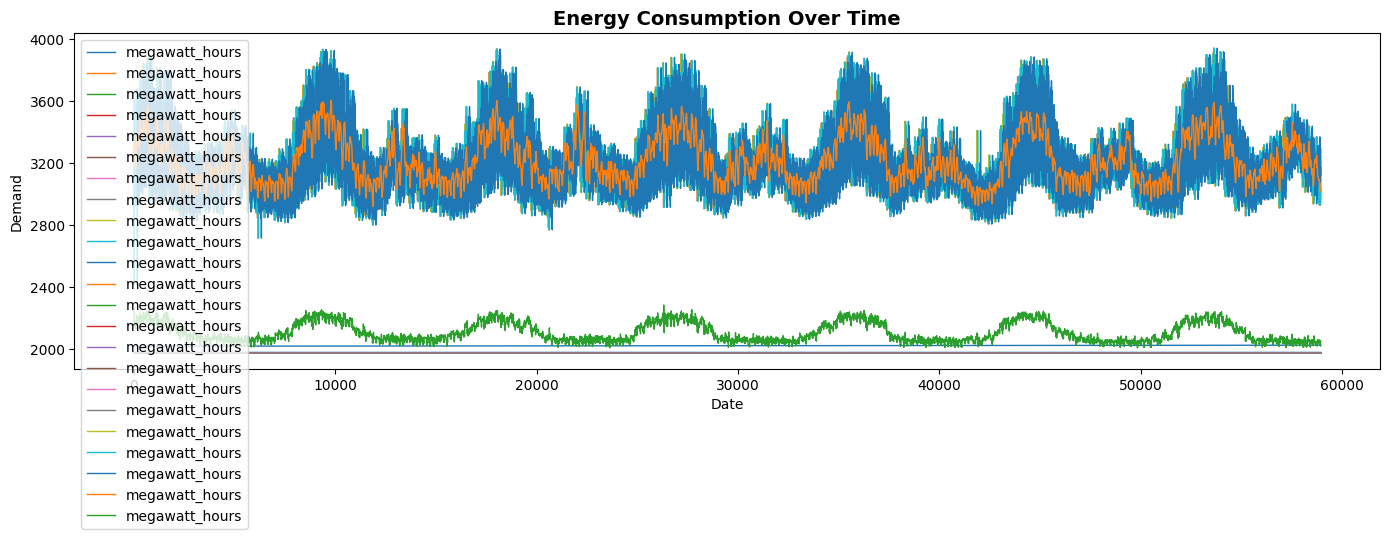

In [28]:
plt.figure(figsize=(14, 5))
plt.plot(df, label='megawatt_hours', linewidth=1)
plt.title('Energy Consumption Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.tight_layout()
plt.show()

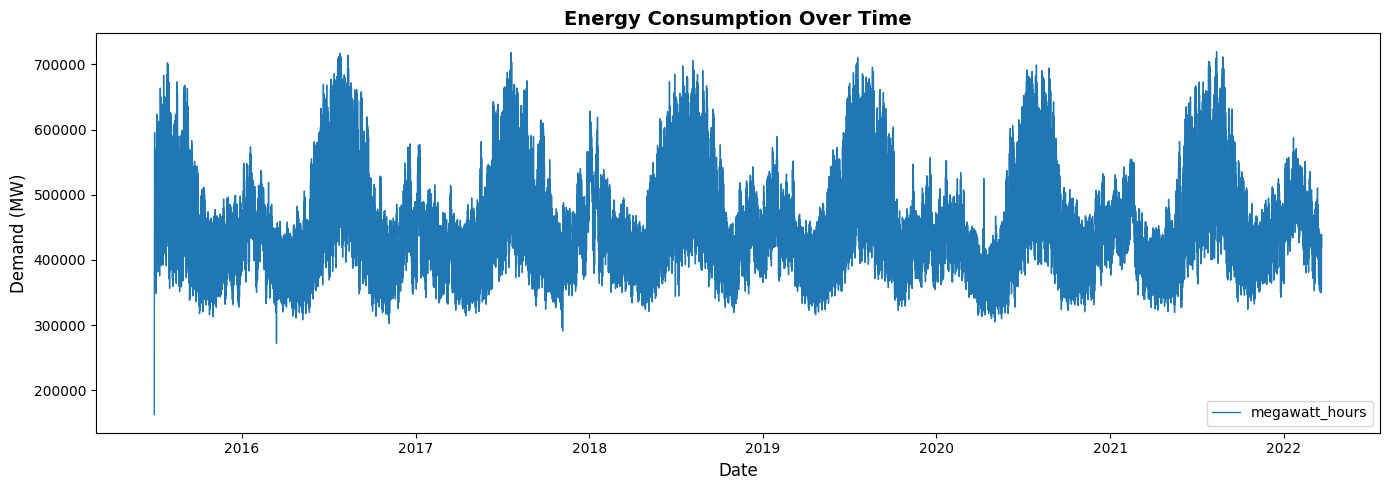

In [29]:
plt.figure(figsize=(14, 5))
plt.plot(df['datetime'], df['megawatt_hours'], label='megawatt_hours', linewidth=1)
plt.title('Energy Consumption Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Demand (MW)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
correlation_matrix = df.corr()


In [31]:
correlation_matrix

,datetime,temperature,humidity,megawatt_hours,hour,day_of_week,day_of_month,week_of_year,month,quarter,...,hour_cos,month_sin,month_cos,dayofweek_sin,dayofweek_cos,lag_1,lag_24,lag_168,rolling_mean_24,rolling_std_24
datetime,1.000000,-0.076156,-0.000860,0.001708,1.351672e-04,0.000353,0.001799,-4.162532e-02,-0.040669,-0.048331,...,-1.471197e-04,0.063980,0.044404,-1.292211e-03,0.001288,0.001722,0.002210,0.005106,0.002558,-0.118441
temperature,-0.076156,1.000000,-0.473408,-0.121715,-2.398509e-01,0.000074,-0.003235,-8.999260e-02,-0.081404,-0.086548,...,-4.001393e-01,0.015983,-0.572027,1.244672e-03,0.002084,-0.195170,-0.122990,-0.129536,-0.031530,0.302430
humidity,-0.000860,-0.473408,1.000000,0.304505,2.003987e-01,0.002125,-0.010440,3.349843e-01,0.336282,0.348882,...,4.445649e-01,-0.507370,-0.151269,4.500632e-03,-0.016940,0.380157,0.305231,0.310572,0.302364,0.427409
megawatt_hours,0.001708,-0.121715,0.304505,1.000000,4.919494e-01,-0.151301,0.002466,2.349309e-02,0.025518,0.027680,...,-2.313628e-01,-0.266219,-0.236374,1.611387e-01,-0.043933,0.978510,0.949901,0.892148,0.690770,0.512647
hour,0.000135,-0.239851,0.200399,0.491949,1.000000e+00,0.000235,-0.000095,1.533826e-04,0.000161,0.000213,...,-1.022677e-01,-0.000227,0.000006,-7.063470e-08,-0.000222,0.491855,0.492055,0.492409,-0.000033,0.004566
day_of_week,0.000353,0.000074,0.002125,-0.151301,2.354367e-04,1.000000,-0.000117,4.003421e-04,-0.000395,0.000072,...,9.143306e-05,0.000194,0.000776,-7.341552e-01,-0.353136,-0.147472,0.020055,-0.151233,-0.083483,-0.049501
day_of_month,0.001799,-0.003235,-0.010440,0.002466,-9.477774e-05,-0.000117,1.000000,7.064028e-02,0.015716,0.019150,...,-3.680742e-05,-0.018254,-0.004542,-2.393716e-03,0.003001,0.002861,0.007823,0.032540,0.008216,0.010695
week_of_year,-0.041625,-0.089993,0.334984,0.023493,1.533826e-04,0.000400,0.070640,1.000000e+00,0.970156,0.947070,...,5.956694e-05,-0.747705,0.210780,-9.581413e-07,-0.000377,0.023415,0.023035,0.038936,0.033670,0.213848
month,-0.040669,-0.081404,0.336282,0.025518,1.612952e-04,-0.000395,0.015716,9.701558e-01,1.000000,0.972208,...,6.263984e-05,-0.757807,0.199313,1.641990e-03,-0.002120,0.025522,0.026432,0.040298,0.037669,0.222983
quarter,-0.048331,-0.086548,0.348882,0.027680,2.126810e-04,0.000072,0.019150,9.470701e-01,0.972208,1.000000,...,8.259575e-05,-0.785299,0.202056,-1.930740e-05,-0.001151,0.027665,0.028348,0.038890,0.040608,0.225977


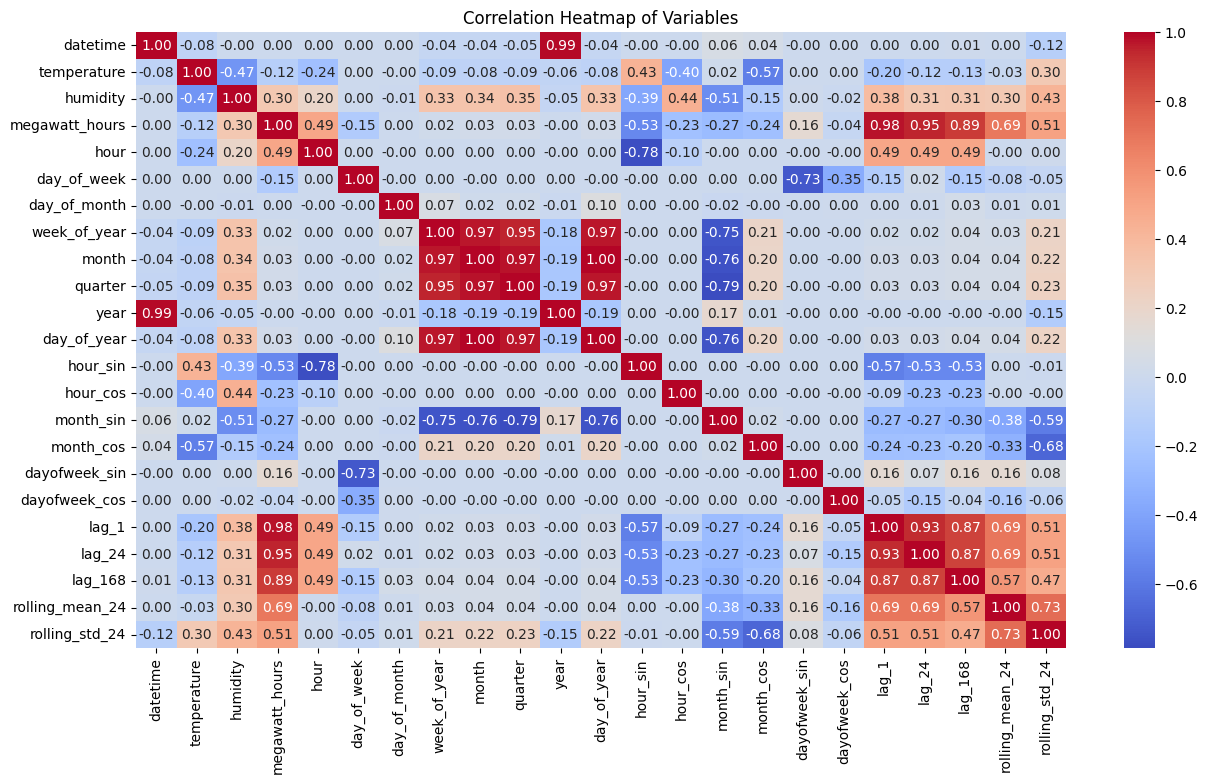

In [32]:
# Create the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Variables')
plt.show()

In [33]:
df.columns

Index(['datetime', 'temperature', 'humidity', 'megawatt_hours', 'hour',
       'day_of_week', 'day_of_month', 'week_of_year', 'month', 'quarter',
       'year', 'day_of_year', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
       'dayofweek_sin', 'dayofweek_cos', 'lag_1', 'lag_24', 'lag_168',
       'rolling_mean_24', 'rolling_std_24'],
      dtype='object')

In [34]:
f_df = df[['datetime', 'temperature', 'humidity', 'megawatt_hours', 'hour', 'day_of_week', 'day_of_month', 'week_of_year', 'month', 'quarter', 'year', 'day_of_year']]


In [35]:
f_df

,datetime,temperature,humidity,megawatt_hours,hour,day_of_week,day_of_month,week_of_year,month,quarter,year,day_of_year
0,2015-07-01 00:00:00,24.8,95,162827.0,0,2,1,27,7,3,2015,182
1,2015-07-01 01:00:00,25.1,94,335153.0,1,2,1,27,7,3,2015,182
2,2015-07-01 02:00:00,25.8,90,333837.0,2,2,1,27,7,3,2015,182
3,2015-07-01 03:00:00,26.2,87,398386.0,3,2,1,27,7,3,2015,182
4,2015-07-01 04:00:00,27.4,82,388954.0,4,2,1,27,7,3,2015,182
...,...,...,...,...,...,...,...,...,...,...,...,...
58931,2022-03-21 11:00:00,34.0,31,433344.0,11,0,21,12,3,1,2022,80
58932,2022-03-21 12:00:00,33.1,35,429156.0,12,0,21,12,3,1,2022,80
58933,2022-03-21 13:00:00,29.9,44,426496.0,13,0,21,12,3,1,2022,80
58934,2022-03-21 14:00:00,29.2,41,423393.0,14,0,21,12,3,1,2022,80


In [36]:
correlation = f_df.corr()


In [37]:
correlation

,datetime,temperature,humidity,megawatt_hours,hour,day_of_week,day_of_month,week_of_year,month,quarter,year,day_of_year
datetime,1.000000,-0.076156,-0.000860,0.001708,0.000135,0.000353,0.001799,-0.041625,-0.040669,-0.048331,0.988973,-0.040428
temperature,-0.076156,1.000000,-0.473408,-0.121715,-0.239851,0.000074,-0.003235,-0.089993,-0.081404,-0.086548,-0.062345,-0.083816
humidity,-0.000860,-0.473408,1.000000,0.304505,0.200399,0.002125,-0.010440,0.334984,0.336282,0.348882,-0.050354,0.333545
megawatt_hours,0.001708,-0.121715,0.304505,1.000000,0.491949,-0.151301,0.002466,0.023493,0.025518,0.027680,-0.002291,0.025370
hour,0.000135,-0.239851,0.200399,0.491949,1.000000,0.000235,-0.000095,0.000153,0.000161,0.000213,-0.000290,0.000155
day_of_week,0.000353,0.000074,0.002125,-0.151301,0.000235,1.000000,-0.000117,0.000400,-0.000395,0.000072,0.000407,-0.000409
day_of_month,0.001799,-0.003235,-0.010440,0.002466,-0.000095,-0.000117,1.000000,0.070640,0.015716,0.019150,-0.012725,0.097785
week_of_year,-0.041625,-0.089993,0.334984,0.023493,0.000153,0.000400,0.070640,1.000000,0.970156,0.947070,-0.184913,0.971528
month,-0.040669,-0.081404,0.336282,0.025518,0.000161,-0.000395,0.015716,0.970156,1.000000,0.972208,-0.187692,0.996597
quarter,-0.048331,-0.086548,0.348882,0.027680,0.000213,0.000072,0.019150,0.947070,0.972208,1.000000,-0.191172,0.969263


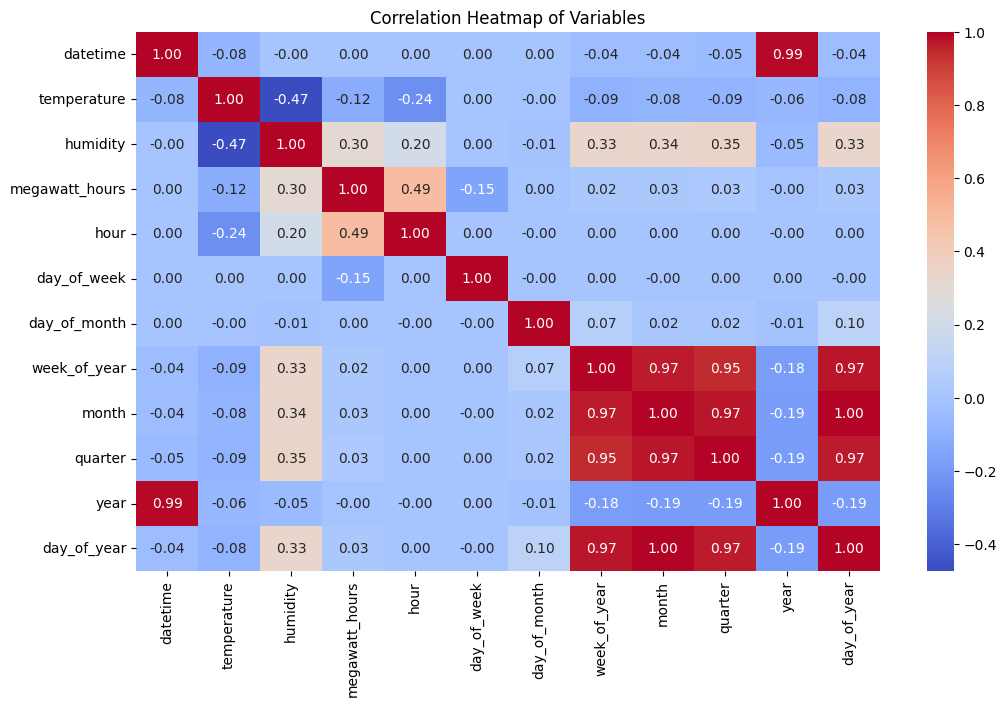

In [38]:
# Create the heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Variables')
plt.show()

In [39]:
final_df = df[['datetime', 'temperature', 'humidity', 'megawatt_hours', 'hour', 'day_of_week', 'month']]


In [40]:
final_df

,datetime,temperature,humidity,megawatt_hours,hour,day_of_week,month
0,2015-07-01 00:00:00,24.8,95,162827.0,0,2,7
1,2015-07-01 01:00:00,25.1,94,335153.0,1,2,7
2,2015-07-01 02:00:00,25.8,90,333837.0,2,2,7
3,2015-07-01 03:00:00,26.2,87,398386.0,3,2,7
4,2015-07-01 04:00:00,27.4,82,388954.0,4,2,7
...,...,...,...,...,...,...,...
58931,2022-03-21 11:00:00,34.0,31,433344.0,11,0,3
58932,2022-03-21 12:00:00,33.1,35,429156.0,12,0,3
58933,2022-03-21 13:00:00,29.9,44,426496.0,13,0,3
58934,2022-03-21 14:00:00,29.2,41,423393.0,14,0,3


In [41]:
correlation_df = final_df.corr()

In [42]:
correlation_df

,datetime,temperature,humidity,megawatt_hours,hour,day_of_week,month
datetime,1.000000,-0.076156,-0.000860,0.001708,0.000135,0.000353,-0.040669
temperature,-0.076156,1.000000,-0.473408,-0.121715,-0.239851,0.000074,-0.081404
humidity,-0.000860,-0.473408,1.000000,0.304505,0.200399,0.002125,0.336282
megawatt_hours,0.001708,-0.121715,0.304505,1.000000,0.491949,-0.151301,0.025518
hour,0.000135,-0.239851,0.200399,0.491949,1.000000,0.000235,0.000161
day_of_week,0.000353,0.000074,0.002125,-0.151301,0.000235,1.000000,-0.000395
month,-0.040669,-0.081404,0.336282,0.025518,0.000161,-0.000395,1.000000


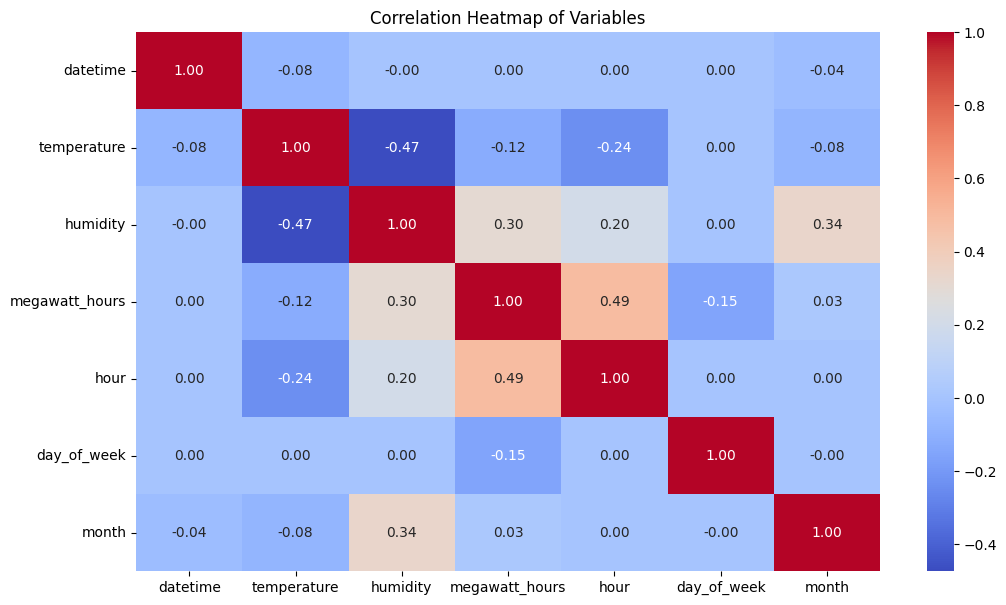

In [43]:
# Create the heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Variables')
plt.show()

In [44]:
final_df

,datetime,temperature,humidity,megawatt_hours,hour,day_of_week,month
0,2015-07-01 00:00:00,24.8,95,162827.0,0,2,7
1,2015-07-01 01:00:00,25.1,94,335153.0,1,2,7
2,2015-07-01 02:00:00,25.8,90,333837.0,2,2,7
3,2015-07-01 03:00:00,26.2,87,398386.0,3,2,7
4,2015-07-01 04:00:00,27.4,82,388954.0,4,2,7
...,...,...,...,...,...,...,...
58931,2022-03-21 11:00:00,34.0,31,433344.0,11,0,3
58932,2022-03-21 12:00:00,33.1,35,429156.0,12,0,3
58933,2022-03-21 13:00:00,29.9,44,426496.0,13,0,3
58934,2022-03-21 14:00:00,29.2,41,423393.0,14,0,3


In [45]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [48]:
final_df.columns = ['datetime', 'temperature', 'humidity', 'megawatt_hours', 'hour', 'day_of_week', 'month']


In [49]:
# Ensure the datetime column is the index and the data type is float/numeric
time_series = final_df.set_index('datetime')['megawatt_hours'].astype(float)

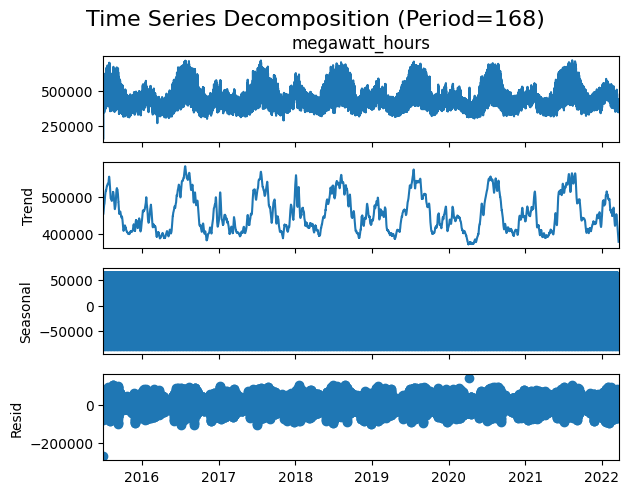


Decomposition successful. Check the plot for clear seasonality.


In [52]:
period_val = 168 


result = seasonal_decompose(
    time_series, 
    model='additive', 
    period=period_val, 
    extrapolate_trend='freq' # Helps fill NaNs at the start/end of the trend
)

# --- 4. Plot the Decomposition ---

result.plot()
plt.suptitle(f'Time Series Decomposition (Period={period_val})', y=1.02, fontsize=16)
plt.show()

# --- 5. Access the Components ---

# You can access the individual components like this:
trend = result.trend
seasonal = result.seasonal
residual = result.resid

print("\nDecomposition successful. Check the plot for clear seasonality.")
# print(seasonal.head()) # Uncomment to inspect the seasonal component values

In [54]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Example: assuming df1 has 'Date' and 'megawatt' columns
final_df['datetime'] = pd.to_datetime(final_df['datetime'])
final_df.set_index('datetime', inplace=True)

# Apply ADF test
result = adfuller(final_df['megawatt_hours'])

# Print results
print("ADF Statistic: ", result[0])
print("p-value: ", result[1])
print("No. of Lags Used: ", result[2])
print("Number of Observations Used: ", result[3])
print("Critical Values: ")
for key, value in result[4].items():
    print(f"   {key}: {value:.3f}")

# Interpretation
if result[1] <= 0.05:
    print("\n✅ Strong evidence against the null hypothesis — the data is STATIONARY.")
else:
    print("\n❌ Weak evidence against the null hypothesis — the data is NON-STATIONARY.")


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1240\2774561899.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['datetime'] = pd.to_datetime(final_df['datetime'])


ADF Statistic:  -9.440169136944688
p-value:  4.919079400273782e-16
No. of Lags Used:  60
Number of Observations Used:  58875
Critical Values: 
   1%: -3.430
   5%: -2.862
   10%: -2.567

✅ Strong evidence against the null hypothesis — the data is STATIONARY.


In [55]:
final_df

,temperature,humidity,megawatt_hours,hour,day_of_week,month
datetime,,,,,,
2015-07-01 00:00:00,24.8,95,162827.0,0,2,7
2015-07-01 01:00:00,25.1,94,335153.0,1,2,7
2015-07-01 02:00:00,25.8,90,333837.0,2,2,7
2015-07-01 03:00:00,26.2,87,398386.0,3,2,7
2015-07-01 04:00:00,27.4,82,388954.0,4,2,7
...,...,...,...,...,...,...
2022-03-21 11:00:00,34.0,31,433344.0,11,0,3
2022-03-21 12:00:00,33.1,35,429156.0,12,0,3
2022-03-21 13:00:00,29.9,44,426496.0,13,0,3


In [56]:
# ===============================================================
# 📘 SARIMAX Forecasting End-to-End Model
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [57]:
# Target and features
target_col = 'megawatt_hours'
feature_cols = ['temperature', 'humidity', 'hour', 'day_of_week', 'month']

In [58]:
y = final_df[target_col]
X = final_df[feature_cols]

In [61]:
y.head(2)

datetime
2015-07-01 00:00:00    162827.0
2015-07-01 01:00:00    335153.0
Name: megawatt_hours, dtype: float64

In [62]:
X.head(2)

,temperature,humidity,hour,day_of_week,month
datetime,,,,,
2015-07-01 00:00:00,24.8,95,0,2,7
2015-07-01 01:00:00,25.1,94,1,2,7


In [ ]:
# ===============================================================
# 2️⃣ TRAIN-TEST SPLIT (90% train, 10% test)
# ===============================================================
split_index = int(len(final_df) * 0.8)
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]

In [65]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(47148, 5)
(11788, 5)
(47148,)
(11788,)


In [66]:
# ===============================================================
# 3️⃣ TRAIN SARIMAX MODEL
# ===============================================================
print("🔧 Training SARIMAX model...")

model = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(1, 0, 1),             # (p,d,q)
    seasonal_order=(1, 0, 1, 24), # (P,D,Q,s) - s=24 if hourly data
    enforce_stationarity=False,
    enforce_invertibility=False
)

🔧 Training SARIMAX model...


In [67]:
model_fit = model.fit(disp=False)


In [68]:
model_fit

In [69]:
# ===============================================================
# 4️⃣ EVALUATE ON TEST SET
# ===============================================================
print("🔮 Making predictions on test data...")
y_pred = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"📊 Model Performance:\nMAE = {mae:.2f}\nRMSE = {rmse:.2f}\n")

🔮 Making predictions on test data...
📊 Model Performance:
MAE = 62528.52
RMSE = 77724.22



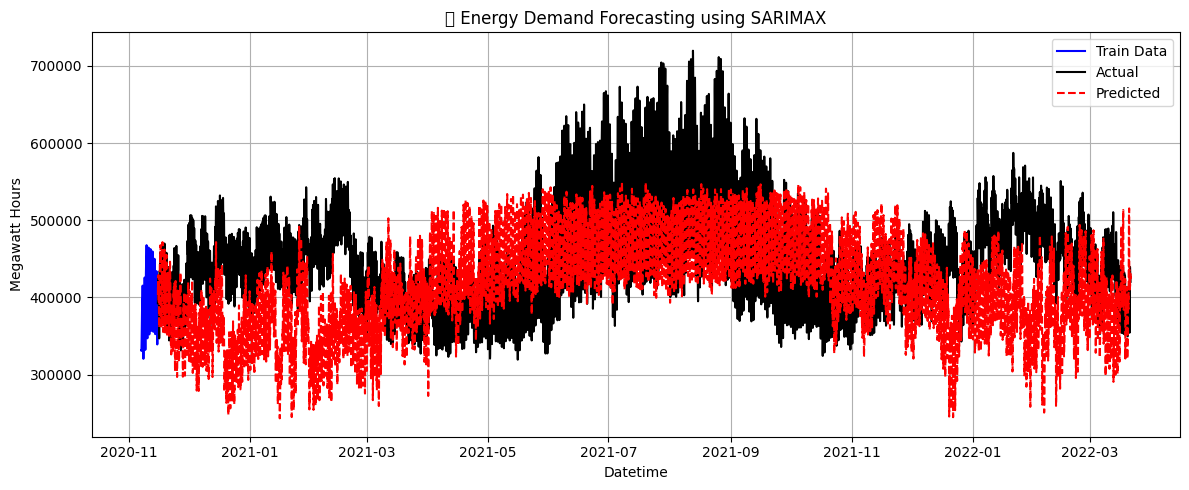

In [70]:
# ===============================================================
# 5️⃣ VISUALIZE ACTUAL VS PREDICTED
# ===============================================================
plt.figure(figsize=(12, 5))
plt.plot(y_train[-200:], label='Train Data', color='blue')
plt.plot(y_test, label='Actual', color='black')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title("🔋 Energy Demand Forecasting using SARIMAX")
plt.xlabel("Datetime")
plt.ylabel("Megawatt Hours")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [88]:
from pandas.tseries.frequencies import to_offset # <--- CORRECTIVE IMPORT

In [89]:
# -------------------------------------------------------------------
# 5. BUILD FUTURE INDEX STARTING FROM CURRENT DATE/TIME (aligned)
# -------------------------------------------------------------------
# detect frequency
freq = pd.infer_freq(final_df.index)
if freq is None:
    # fallback by median delta
    median_delta = (final_df.index.to_series().diff().median())
    if median_delta <= pd.Timedelta(hours=1):
        freq = 'H'
    elif median_delta <= pd.Timedelta(days=1):
        freq = 'D'
    else:
        freq = 'D'
print("Inferred freq:", freq)

# compute offset and number of periods that cover 30 days
offset = to_offset(freq)
try:
    periods = int(pd.Timedelta(days=30) / offset)
except Exception:
    # fallback heuristics
    if 'H' in freq.upper():
        periods = 30 * 24
    elif 'D' in freq.upper():
        periods = 30
    else:
        periods = 30

# choose start aligned to freq and at/after current time
last_date = final_df.index[-1]
now = pd.Timestamp.now(tz=last_date.tz) if getattr(last_date, 'tz', None) else pd.Timestamp.now()
candidate_start = last_date + offset
# if candidate_start < now, start from now rounded up to the freq boundary, else start from candidate_start
try:
    if candidate_start < now:
        start = now.ceil(freq)
    else:
        start = candidate_start
except Exception:
    # if ceil not supported, fallback to candidate_start
    start = candidate_start

future_index = pd.date_range(start=start, periods=periods, freq=freq)
print("Future index starts at:", future_index[0], "periods:", periods)


Inferred freq: h
Future index starts at: 2025-10-20 10:00:00 periods: 720


In [90]:
# -------------------------------------------------------------------
# 6. CREATE EXOG FOR FUTURE PERIODS (estimated)
# -------------------------------------------------------------------
future_df = pd.DataFrame(index=future_index)
future_df['hour'] = future_df.index.hour
future_df['day_of_week'] = future_df.index.dayofweek
future_df['month'] = future_df.index.month

In [91]:
future_df

,hour,day_of_week,month
2025-10-20 10:00:00,10,0,10
2025-10-20 11:00:00,11,0,10
2025-10-20 12:00:00,12,0,10
2025-10-20 13:00:00,13,0,10
2025-10-20 14:00:00,14,0,10
...,...,...,...
2025-11-19 05:00:00,5,2,11
2025-11-19 06:00:00,6,2,11
2025-11-19 07:00:00,7,2,11
2025-11-19 08:00:00,8,2,11


In [92]:
# Estimate temperature/humidity intelligently:
if 'H' in freq.upper():   # hourly data -> map by hour-of-day averages
    temp_map = X.groupby(X.index.hour)['temperature'].mean()
    hum_map  = X.groupby(X.index.hour)['humidity'].mean()
    future_df['temperature'] = future_df['hour'].map(temp_map).fillna(X['temperature'].mean())
    future_df['humidity'] = future_df['hour'].map(hum_map).fillna(X['humidity'].mean())
else:  # daily or lower -> map by month averages
    temp_map = X.groupby(X.index.month)['temperature'].mean()
    hum_map  = X.groupby(X.index.month)['humidity'].mean()
    future_df['temperature'] = future_df['month'].map(temp_map).fillna(X['temperature'].mean())
    future_df['humidity'] = future_df['month'].map(hum_map).fillna(X['humidity'].mean())

# Ensure column order matches training exog
future_exog = future_df[['temperature', 'humidity', 'hour', 'day_of_week', 'month']]

In [93]:
future_exog

,temperature,humidity,hour,day_of_week,month
2025-10-20 10:00:00,30.763233,53.024837,10,0,10
2025-10-20 11:00:00,29.887174,57.945847,11,0,10
2025-10-20 12:00:00,28.434039,62.607899,12,0,10
2025-10-20 13:00:00,27.123819,66.171824,13,0,10
2025-10-20 14:00:00,26.290309,69.270765,14,0,10
...,...,...,...,...,...
2025-11-19 05:00:00,29.321946,61.145358,5,2,11
2025-11-19 06:00:00,30.410464,56.450733,6,2,11
2025-11-19 07:00:00,31.032940,53.497964,7,2,11
2025-11-19 08:00:00,31.281433,51.891694,8,2,11


In [94]:
# -------------------------------------------------------------------
# 7. GET FORECAST FOR THE FUTURE INDEX
# -------------------------------------------------------------------
forecast_res = model_fit.get_forecast(steps=periods, exog=future_exog)
forecast_df = forecast_res.summary_frame()
forecast_df.index = future_index  # align

# Show first rows
print("\nDetailed forecast (first 10 rows):")
print(forecast_df[['mean', 'mean_ci_lower', 'mean_ci_upper']].head(10))


Detailed forecast (first 10 rows):
megawatt_hours                mean  mean_ci_lower  mean_ci_upper
2025-10-20 10:00:00  425296.485829  368206.478877  482386.492780
2025-10-20 11:00:00  433500.376517  347612.329405  519388.423629
2025-10-20 12:00:00  432756.948788  327172.644677  538341.252900
2025-10-20 13:00:00  433480.511508  312640.769327  554320.253688
2025-10-20 14:00:00  430291.652471  297002.449159  563580.855784
2025-10-20 15:00:00  430526.705594  286777.723218  574275.687971
2025-10-20 16:00:00  440659.507224  287957.561852  593361.452596
2025-10-20 17:00:00  451236.788799  290772.338182  611701.239416
2025-10-20 18:00:00  453028.714268  285770.230161  620287.198376
2025-10-20 19:00:00  447652.661206  274405.001806  620900.320606


In [95]:
# -------------------------------------------------------------------
# 8. AGGREGATE TO DAILY (user asked: next 30 days)
# -------------------------------------------------------------------
# If original freq is higher than daily (hourly), aggregate forecast to daily (sum or mean as you prefer)
if 'H' in freq.upper():
    # aggregate hourly mean -> daily mean; use sum if you want daily totals
    daily_mean = forecast_df['mean'].resample('D').mean().iloc[:30]
    daily_lower = forecast_df['mean_ci_lower'].resample('D').mean().iloc[:30]
    daily_upper = forecast_df['mean_ci_upper'].resample('D').mean().iloc[:30]
    daily_forecast = pd.DataFrame({
        'mean': daily_mean,
        'ci_lower': daily_lower,
        'ci_upper': daily_upper
    })
else:
    # already at daily resolution
    daily_forecast = forecast_df[['mean', 'mean_ci_lower', 'mean_ci_upper']].rename(
        columns={'mean_ci_lower': 'ci_lower', 'mean_ci_upper': 'ci_upper'}
    ).iloc[:30]

print("\n*** Next 30 DAYS forecast (daily aggregated):")
print(daily_forecast)


*** Next 30 DAYS forecast (daily aggregated):
                     mean       ci_lower       ci_upper
2025-10-20  452145.000686  306375.981406  597914.019966
2025-10-21  424322.031729  201961.173981  646682.889478
2025-10-22  423421.876983  164869.428405  681974.325562
2025-10-23  421016.243459  141714.183701  700318.303217
2025-10-24  418085.759482  122514.055550  713657.463413
2025-10-25  414972.242461  104961.726484  724982.758439
2025-10-26  411794.839753   88347.260640  735242.418866
2025-10-27  431471.862815   95280.643001  767663.082628
2025-10-28  428264.228182   79884.196495  776644.259868
2025-10-29  425053.762327   64962.291024  785145.233629
2025-10-30  421842.224455   50464.236095  793220.212815
2025-10-31  418630.227971   36350.377355  800910.078588
2025-11-01  414872.214328   22042.079049  807702.349608
2025-11-02  411659.803438    8602.841578  814716.765299
2025-11-03  431324.029124   18339.347552  844308.710697
2025-11-04  428111.340512    5476.716113  850745.964911
2

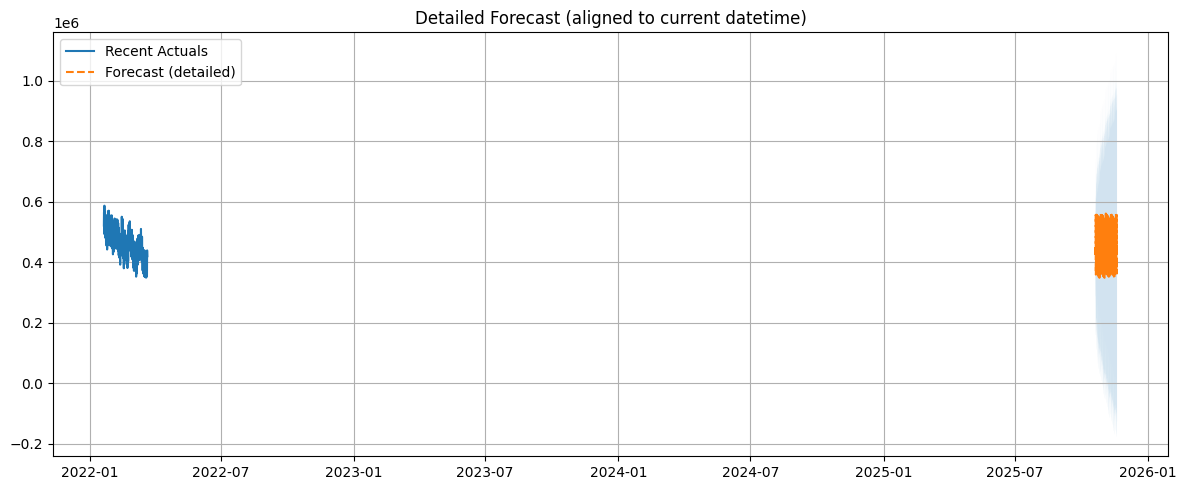

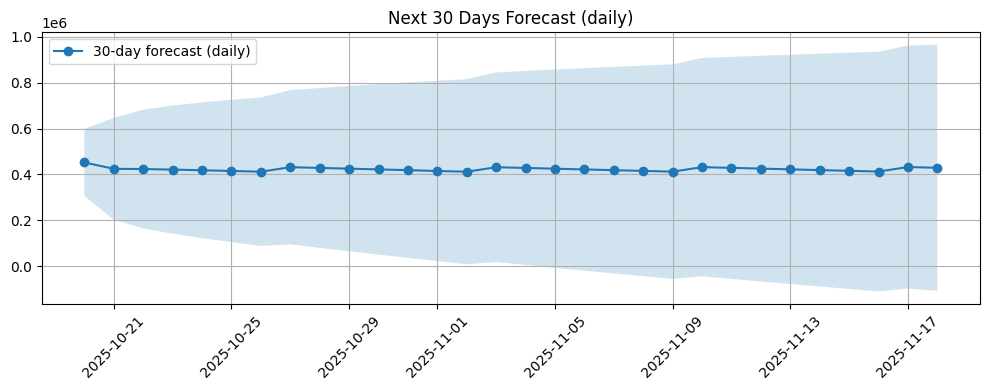

In [96]:
# -------------------------------------------------------------------
# 9. PLOT results
# -------------------------------------------------------------------
plt.figure(figsize=(12,5))
# show recent actuals (last 30 days if available)
try:
    recent = y[-(periods*2):]  # show some recent history
    plt.plot(recent.index, recent.values, label='Recent Actuals')
except Exception:
    pass

plt.plot(forecast_df.index, forecast_df['mean'], label='Forecast (detailed)', linestyle='--')
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], alpha=0.2)
plt.title("Detailed Forecast (aligned to current datetime)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot daily 30-day forecast
plt.figure(figsize=(10,4))
plt.plot(daily_forecast.index, daily_forecast['mean'], marker='o', label='30-day forecast (daily)')
plt.fill_between(daily_forecast.index, daily_forecast['ci_lower'], daily_forecast['ci_upper'], alpha=0.2)
plt.title("Next 30 Days Forecast (daily)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [113]:
# ===============================================================
# 📘 ARIMA – Univariate Time Series Forecasting
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [114]:
final_df.head(2)

,temperature,humidity,megawatt_hours,hour,day_of_week,month
datetime,,,,,,
2015-07-01 00:00:00,24.8,95,162827.0,0,2,7
2015-07-01 01:00:00,25.1,94,335153.0,1,2,7


In [115]:
# ===============================================================
# 1️⃣ LOAD & PREPARE DATA
# ===============================================================
# Your DataFrame must have: ['datetime', 'megawatt_hours']
# Example:
# df = pd.read_csv("Energy_Demand_Forecasting.csv")

df1 = final_df['megawatt_hours']

df1


datetime
2015-07-01 00:00:00    162827.0
2015-07-01 01:00:00    335153.0
2015-07-01 02:00:00    333837.0
2015-07-01 03:00:00    398386.0
2015-07-01 04:00:00    388954.0
                         ...   
2022-03-21 11:00:00    433344.0
2022-03-21 12:00:00    429156.0
2022-03-21 13:00:00    426496.0
2022-03-21 14:00:00    423393.0
2022-03-21 15:00:00    420157.0
Name: megawatt_hours, Length: 58936, dtype: float64

In [116]:
# ===============================================================
# 2️⃣ TRAIN-TEST SPLIT
# ===============================================================
split_index = int(len(df1) * 0.8)
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(y_train.shape)
print(y_test.shape)

(47148,)
(11788,)


In [117]:
# ===============================================================
# 3️⃣ TRAIN ARIMA MODEL
# ===============================================================
print("🔧 Training ARIMA model (p,d,q) = (5,1,0)...")

model_01 = ARIMA(y_train, order=(1, 0, 1))   # simple ARIMA(5,1,0)
model_fit_01 = model_01.fit()
print("✅ Model training complete.\n")

🔧 Training ARIMA model (p,d,q) = (5,1,0)...
✅ Model training complete.



In [118]:
# ===============================================================
# 4️⃣ EVALUATE MODEL ON TEST DATA
# ===============================================================
print("🔮 Making predictions on test data...")
y_pred = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], typ='levels')

mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"📊 Model Performance:\nMAE = {mae:.2f}\nRMSE = {rmse:.2f}\n")

🔮 Making predictions on test data...
📊 Model Performance:
MAE = 83242.56
RMSE = 104561.62



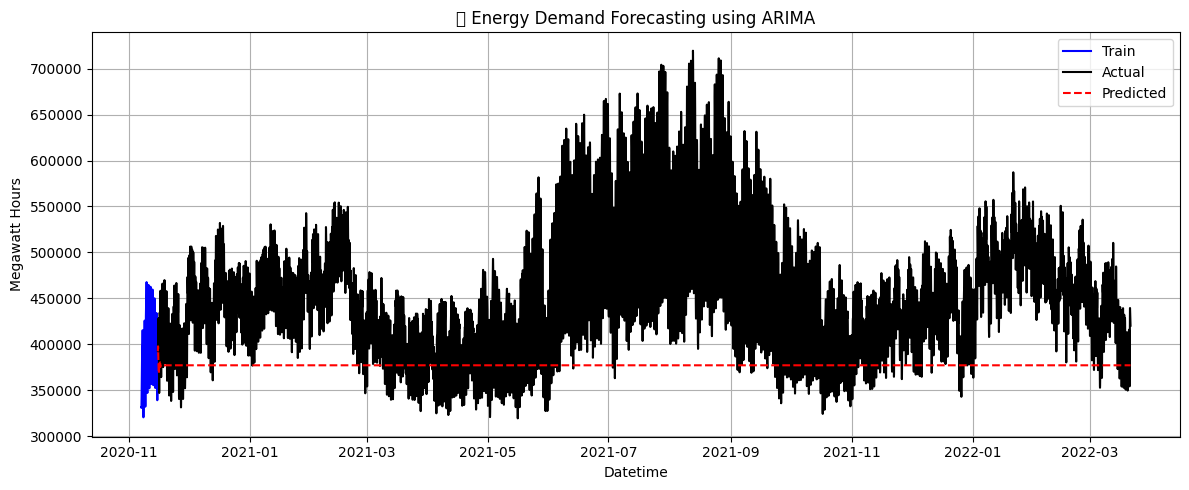

In [119]:
# ===============================================================
# 5️⃣ VISUALIZE ACTUAL VS PREDICTED
# ===============================================================
plt.figure(figsize=(12, 5))
plt.plot(y_train[-200:], label='Train', color='blue')
plt.plot(y_test, label='Actual', color='black')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title("🔋 Energy Demand Forecasting using ARIMA")
plt.xlabel("Datetime")
plt.ylabel("Megawatt Hours")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [122]:
# 5. Determine series frequency and number of forecast steps to cover 30 days
freq = pd.infer_freq(df1.index)
if freq is None:
    # fallback: use median delta to guess hourly or daily
    median_delta = df1.index.to_series().diff().median()
    if median_delta <= pd.Timedelta(hours=1):
        freq = 'H'
    else:
        freq = 'D'
print("Inferred frequency:", freq)

# convert freq to a pandas DateOffset for arithmetic
offset = to_offset(freq)

# compute how many periods correspond to 30 days
try:
    periods_30d = int(pd.Timedelta(days=30) / offset)
except Exception:
    # safe fallback
    periods_30d = 30 * 24 if 'H' in freq.upper() else 30

Inferred frequency: h


In [123]:
# 6. Compute a start timestamp aligned to the frequency and >= now and >= last_date+offset
last_date = df1.index[-1]
now = pd.Timestamp.now()  # uses system local time; should match your environment
# round up to next frequency boundary (if possible)
try:
    now_ceil = now.ceil(freq)
except Exception:
    now_ceil = now

# ensure forecast starts at or after (last_date + one step) AND at/after now_ceil
candidate = last_date + offset
start_time = max(candidate, now_ceil)
print("Last observed:", last_date)
print("Forecast start (aligned to freq and >= now):", start_time)

Last observed: 2022-03-21 15:00:00
Forecast start (aligned to freq and >= now): 2025-10-20 11:00:00


In [124]:
# 7. If there is a gap between last_date and start_time we must skip that many steps in the forecast output
try:
    gap_steps = int((start_time - last_date) / offset) if start_time > last_date else 0
except Exception:
    # fallback (if division fails)
    if 'H' in freq.upper():
        gap_steps = int((start_time - last_date).total_seconds() // 3600)
    else:
        gap_steps = (start_time - last_date).days if (start_time - last_date).days > 0 else 0

total_steps = gap_steps + periods_30d
print(f"Gap steps to advance forecast to start_time: {gap_steps}, total forecast steps requested: {total_steps}")


Gap steps to advance forecast to start_time: 31412, total forecast steps requested: 32132


In [125]:
# 8. Get forecast for total_steps, then keep the tail corresponding to start_time..start_time+30days
forecast_res = model_fit.get_forecast(steps=total_steps)
forecast_df = forecast_res.summary_frame()  # contains mean, se, and ci columns

# select the block that aligns with start_time .. start_time + periods_30d-1
selected = forecast_df.iloc[gap_steps: gap_steps + periods_30d].copy()

# create a proper future index starting at start_time
future_index = pd.date_range(start=start_time, periods=periods_30d, freq=freq)
selected.index = future_index


In [126]:
future_index

DatetimeIndex(['2025-10-20 11:00:00', '2025-10-20 12:00:00',
               '2025-10-20 13:00:00', '2025-10-20 14:00:00',
               '2025-10-20 15:00:00', '2025-10-20 16:00:00',
               '2025-10-20 17:00:00', '2025-10-20 18:00:00',
               '2025-10-20 19:00:00', '2025-10-20 20:00:00',
               ...
               '2025-11-19 01:00:00', '2025-11-19 02:00:00',
               '2025-11-19 03:00:00', '2025-11-19 04:00:00',
               '2025-11-19 05:00:00', '2025-11-19 06:00:00',
               '2025-11-19 07:00:00', '2025-11-19 08:00:00',
               '2025-11-19 09:00:00', '2025-11-19 10:00:00'],
              dtype='datetime64[ns]', length=720, freq='h')

In [128]:
# 9. Show results
print("\nForecast (first 10 rows):")
print(selected[['mean', 'mean_ci_lower', 'mean_ci_upper']].head(10))


Forecast (first 10 rows):
megawatt_hours                mean  mean_ci_lower  mean_ci_upper
2025-10-20 11:00:00  377043.295769  -8.108471e+06   8.862557e+06
2025-10-20 12:00:00  377043.295769  -8.108606e+06   8.862692e+06
2025-10-20 13:00:00  377043.295769  -8.108741e+06   8.862828e+06
2025-10-20 14:00:00  377043.295769  -8.108876e+06   8.862963e+06
2025-10-20 15:00:00  377043.295769  -8.109011e+06   8.863098e+06
2025-10-20 16:00:00  377043.295769  -8.109146e+06   8.863233e+06
2025-10-20 17:00:00  377043.295769  -8.109281e+06   8.863368e+06
2025-10-20 18:00:00  377043.295769  -8.109416e+06   8.863503e+06
2025-10-20 19:00:00  377043.295769  -8.109551e+06   8.863638e+06
2025-10-20 20:00:00  377043.295769  -8.109686e+06   8.863773e+06


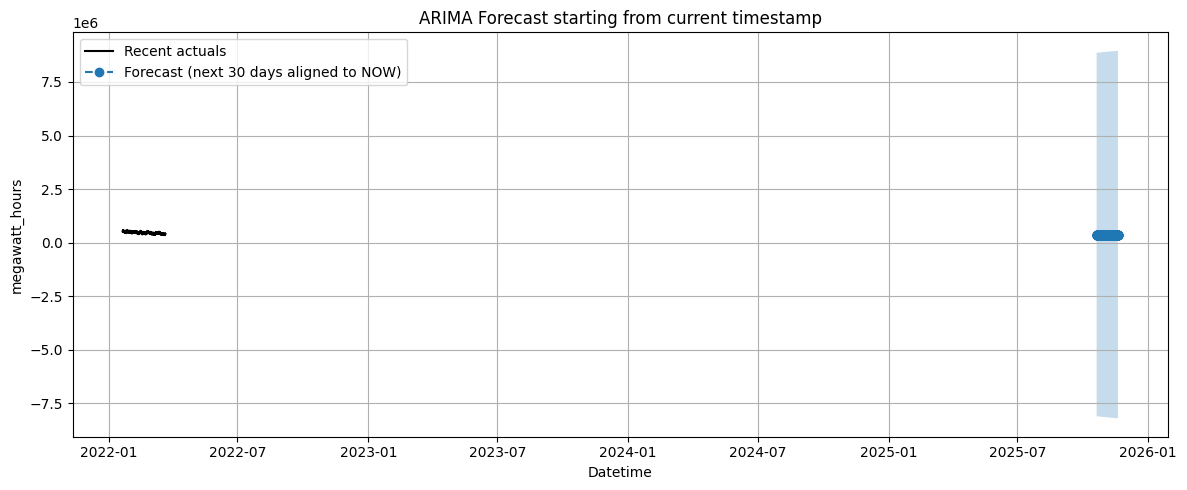

In [129]:
# 10. Plot recent history + forecast (detailed)
plt.figure(figsize=(12,5))
# plot some recent actuals
recent = y[-(periods_30d * 2):] if len(y) > periods_30d * 2 else y
plt.plot(recent.index, recent.values, label='Recent actuals', color='black')
plt.plot(selected.index, selected['mean'], label='Forecast (next 30 days aligned to NOW)', linestyle='--', marker='o')
plt.fill_between(selected.index, selected['mean_ci_lower'], selected['mean_ci_upper'], alpha=0.25)
plt.title("ARIMA Forecast starting from current timestamp")
plt.xlabel("Datetime")
plt.ylabel("megawatt_hours")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Daily-aggregated 30-day forecast (first 7 rows):
                     mean      ci_lower      ci_upper
2025-10-20  377043.295769 -8.109281e+06  8.863368e+06
2025-10-21  377043.295769 -8.111779e+06  8.865865e+06
2025-10-22  377043.295769 -8.115018e+06  8.869105e+06
2025-10-23  377043.295769 -8.118256e+06  8.872343e+06
2025-10-24  377043.295769 -8.121493e+06  8.875580e+06
2025-10-25  377043.295769 -8.124729e+06  8.878815e+06
2025-10-26  377043.295769 -8.127963e+06  8.882050e+06


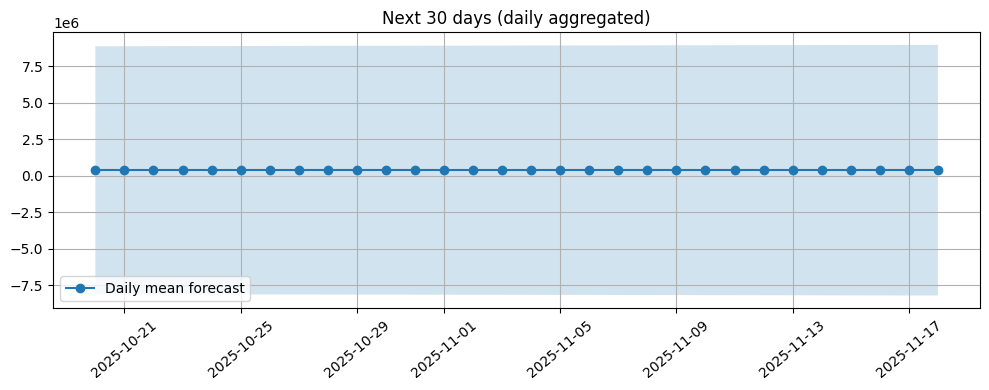

In [130]:
# 11. (Optional) Aggregate to daily if freq is higher than daily and you want daily values
if 'H' in freq.upper():
    daily = selected['mean'].resample('D').mean().iloc[:30]   # choose mean or sum depending on requirement
    daily_lower = selected['mean_ci_lower'].resample('D').mean().iloc[:30]
    daily_upper = selected['mean_ci_upper'].resample('D').mean().iloc[:30]
    daily_df = pd.DataFrame({'mean': daily, 'ci_lower': daily_lower, 'ci_upper': daily_upper})
    print("\nDaily-aggregated 30-day forecast (first 7 rows):")
    print(daily_df.head(7))
    # plot daily
    plt.figure(figsize=(10,4))
    plt.plot(daily_df.index, daily_df['mean'], marker='o', label='Daily mean forecast')
    plt.fill_between(daily_df.index, daily_df['ci_lower'], daily_df['ci_upper'], alpha=0.2)
    plt.title("Next 30 days (daily aggregated)")
    plt.xticks(rotation=40)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()